In [1]:
# ==============================================================================
# CELL 1: SETUP AND CONFIGURATION
# ==============================================================================

# 1. Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 2. Set up simulation parameters
# These parameters define the "universe" of our simulation, based on the project description.

# --- Data Generating Process (DGP) Parameters ---
T_tr = 1000        # Number of training samples
c = 10.0           # True DGP complexity (c = P / T_tr)
P = int(c * T_tr)  # Number of true features, derived from c and T_tr
T_te = 5000       # Number of test samples for out-of-sample evaluation
b_star = 0.2       # Signal strength, defined as the squared L2 norm of beta_true

# --- Simulation Grid Parameters ---
# The grid of shrinkage parameters (z) to loop over
z_grid = [0, 0.01, 0.1, 0.25, 0.5, 1, 2, 5, 10, 25, 50, 100]

# The grid of observed complexities (cq) to loop over
cq_grid = [0.5, 0.75, 0.9, 0.95, 0.98, 1.02, 1.05, 1.1, 1.25, 1.5, 2, 3, 5, 7, 10]

# --- Other Settings ---
# Set a random seed for reproducibility. This is crucial.
# It ensures that anyone running this code will get the exact same results.
SEED = 12345
rng = np.random.default_rng(seed=SEED)

# --- Print a summary of the setup ---
print("--- Simulation Setup ---")
print(f"Training samples (T_tr): {T_tr}")
print(f"Test samples (T_te):     {T_te}")
print(f"True DGP complexity (c): {c}")
print(f"Total features (P):      {P}")
print(f"Signal strength (b*):    {b_star}")
print("------------------------")

--- Simulation Setup ---
Training samples (T_tr): 1000
Test samples (T_te):     5000
True DGP complexity (c): 10.0
Total features (P):      10000
Signal strength (b*):    0.2
------------------------


In [2]:
# ==============================================================================
# CELL 2: DATA GENERATING PROCESS (DGP) FUNCTION
# ==============================================================================

def generate_dgp(T, P, b_star, rng):
    """
    Generates data according to the Data Generating Process (DGP) specified
    in the KMZ paper and the project description.

    Args:
        T (int): The total number of time periods (samples).
        P (int): The total number of features.
        b_star (float): The squared norm of the true beta vector, representing signal strength.
        rng (numpy.random.Generator): The random number generator for reproducibility.

    Returns:
        S (np.ndarray): The feature matrix of shape (T, P).
        R_next (np.ndarray): The next-period return vector of shape (T,).
        beta_true (np.ndarray): The true beta vector of shape (P,).
    """
    # 1. Generate the signal matrix S with covariance = I.
    # Corresponds to the requirement: "Generate S with Ψ=I (rows S_t ~ N(0, I_P))"
    S = rng.normal(size=(T, P))

    # 2. Generate a dense, isotropic true beta vector and normalize its norm.
    # Corresponds to: "Generate dense β* and normalize to ||β*||₂² = b*"
    beta_true = rng.normal(size=P)
    norm_beta = np.linalg.norm(beta_true)
    beta_true = (np.sqrt(b_star) / norm_beta) * beta_true

    # 3. Generate the returns using the forward operator.
    # Corresponds to: "R_t+1 = S_t'β* + ε_t+1"
    eps = rng.normal(size=T)
    R_next = S @ beta_true + eps

    return S, R_next, beta_true

In [3]:
# ==============================================================================
# CELL 3: THE MAIN SIMULATION LOOP 
# ==============================================================================

# 1. Generate the one, true, underlying dataset that represents reality.
# The relationship between S_total and R_next_total is the ground truth.
T_total = T_tr + T_te
S_total, R_next_total, _ = generate_dgp(T_total, P, b_star, rng)

# 2. The analyst does not see the "true" order of features.
# We create the analyst's view by shuffling the columns of S ONCE.
shuffled_indices = rng.permutation(P)
S_total_shuffled = S_total[:, shuffled_indices]

# 3. Split the analyst's view (S_total_shuffled) and the true returns (R_next_total)
# into training and testing sets. The row-wise alignment is preserved.
S_train = S_total_shuffled[:T_tr, :]
R_train = R_next_total[:T_tr]

S_test = S_total_shuffled[T_tr:, :]
R_test = R_next_total[T_tr:]

# (The rest of the code is identical to the first version we ran)

# 4. Prepare a list to store the results
results = []

# 5. Start the main loops
print("Starting simulation loop with final, corrected logic... This may take a moment.")

for cq in cq_grid:
    P1 = int(cq * T_tr)
    if P1 > P: continue
    
    for z in z_grid:
        S_train_p1 = S_train[:, :P1]
        S_test_p1 = S_test[:, :P1]
        X, y = S_train_p1, R_train
        
        if z == 0:
            beta_hat = np.linalg.pinv(X) @ y
        else:
            identity_matrix = np.identity(P1)
            A = X.T @ X + z * T_tr * identity_matrix
            b = X.T @ y
            beta_hat = np.linalg.inv(A) @ b

        R_pred_oos = S_test_p1 @ beta_hat
        
        param_size = np.linalg.norm(beta_hat)**2
        timing_return_series = R_pred_oos * R_test
        expected_timing_return = np.mean(timing_return_series)
        denominator_sr = np.sqrt(np.mean(timing_return_series**2))
        sharpe_ratio = expected_timing_return / denominator_sr if denominator_sr != 0 else 0
        e_r_pred_r_test = np.mean(R_pred_oos * R_test)
        e_r_pred_sq = np.mean(R_pred_oos**2)
        e_r_test_sq = np.mean(R_test**2)
        r_squared = (2 * e_r_pred_r_test - e_r_pred_sq) / e_r_test_sq

        results.append({
            'cq': cq, 'z': z, 'P1': P1, 'param_size': param_size,
            'expected_timing_return': expected_timing_return,
            'sharpe_ratio': sharpe_ratio, 'r_squared': r_squared
        })

# 6. Convert to DataFrame
results_df = pd.DataFrame(results)

print("Simulation loop finished.")
print("First 5 rows of the final results DataFrame:")
display(results_df.head())

Starting simulation loop with final, corrected logic... This may take a moment.
Simulation loop finished.
First 5 rows of the final results DataFrame:


,cq,z,P1,param_size,expected_timing_return,sharpe_ratio,r_squared
0,0.5,0.00,500,1.324331,0.022600,0.017785,-1.025304
1,0.5,0.01,500,1.219563,0.022815,0.018696,-0.941435
2,0.5,0.10,500,0.720014,0.022673,0.024074,-0.543832
3,0.5,0.25,500,0.427445,0.020685,0.028403,-0.313199
4,0.5,0.50,500,0.247702,0.017726,0.031887,-0.173108


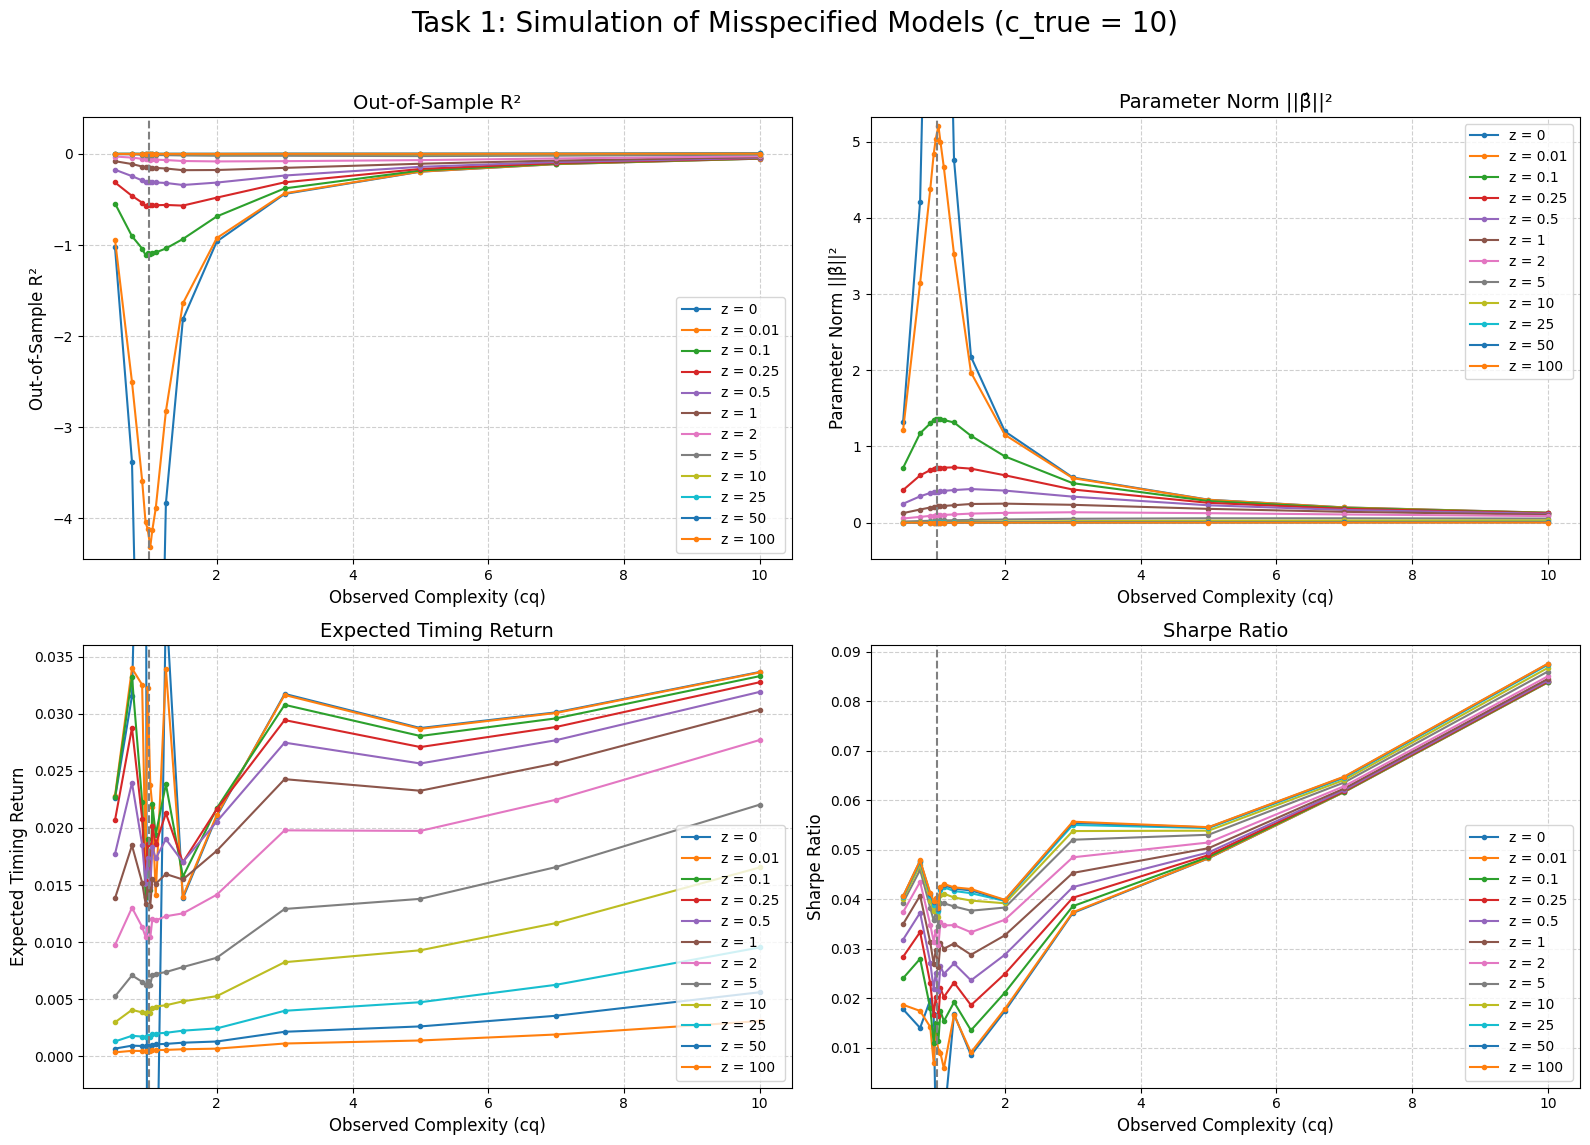

In [4]:
# ==============================================================================
# CELL 4: PLOTTING THE RESULTS (FINAL VERSION WITH DYNAMIC Y-LIMITS)
# ==============================================================================

# Create a 2x2 grid for our four plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Task 1: Simulation of Misspecified Models (c_true = 10)', fontsize=20)

# Flatten the 2x2 axes array into a 1D array for easier iteration
axes = axes.flatten()

# Define the metrics we want to plot
metrics_to_plot = {
    'r_squared': 'Out-of-Sample R²',
    'param_size': 'Parameter Norm ||β̂||²',
    'expected_timing_return': 'Expected Timing Return',
    'sharpe_ratio': 'Sharpe Ratio'
}

# Loop through each metric and create its corresponding plot
for i, (metric, title) in enumerate(metrics_to_plot.items()):
    ax = axes[i]
    
    # ***** THIS IS THE NEW DYNAMIC Y-LIMITS LOGIC *****
    # Calculate y-limits based on the data, excluding extreme outliers
    y_data = results_df[metric]
    # Ensure we only use finite values for quantile calculation
    y_data_finite = y_data[np.isfinite(y_data)]
    
    # Calculate the 5th and 95th percentiles to find a reasonable range
    ylim_low = y_data_finite.quantile(0.05)
    ylim_high = y_data_finite.quantile(0.95)
    
    # Add some padding (e.g., 10% of the range) for better visualization
    padding = (ylim_high - ylim_low) * 0.1
    ax.set_ylim(ylim_low - padding, ylim_high + padding)
    
    # (The rest of the plotting code is the same as before)
    
    # Loop through each shrinkage value `z` to plot its line
    for z in z_grid:
        subset = results_df[results_df['z'] == z]
        ax.plot(subset['cq'], subset[metric], marker='o', linestyle='-', markersize=3, label=f'z = {z}')
        
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Observed Complexity (cq)', fontsize=12)
    ax.set_ylabel(title, fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Add a vertical line at the interpolation boundary cq=1
    ax.axvline(x=1.0, color='grey', linestyle='--', linewidth=1.5, label='cq = 1')

# Adjust layout to prevent titles from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()